In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.figsize'] = (7, 5)


data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # 0 = malignant, 1 = benign

X.sample(5, random_state=RANDOM_STATE)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


In [4]:
from sklearn.decomposition import PCA
N_FEATURES = 2
pca = PCA(n_components=N_FEATURES, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

print(f"Componentes: {N_FEATURES} | Varianza explicada acumulada: {pca.explained_variance_ratio_.sum():.3f}")
print("Varianza por componente:", np.round(pca.explained_variance_ratio_, 3), "\n")

Componentes: 2 | Varianza explicada acumulada: 0.998
Varianza por componente: [0.982 0.016] 



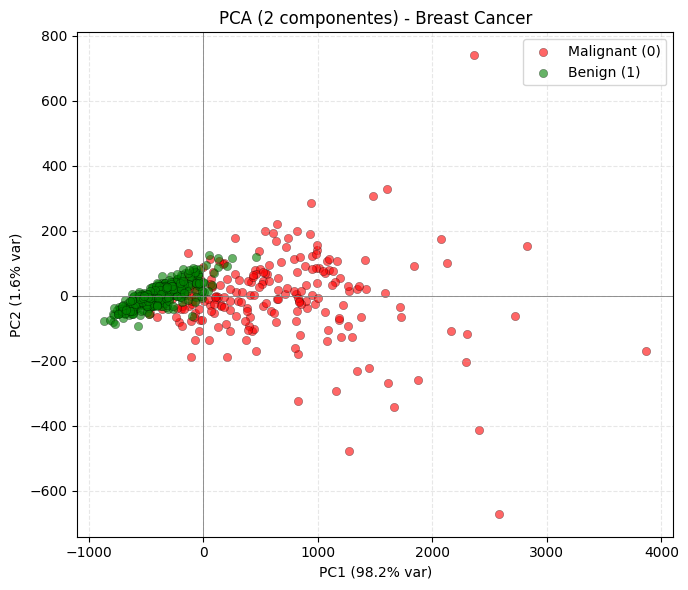

In [6]:
# Si ya tienes X_pca y pca hechos como en tu snippet:
# X_pca = pca.fit_transform(X)

plt.figure(figsize=(7,6))
m0 = (y == 0)  # malignant
m1 = (y == 1)  # benign

plt.scatter(X_pca[m0, 0], X_pca[m0, 1], c='red',   label='Malignant (0)', alpha=0.6, edgecolors='k', linewidths=0.3)
plt.scatter(X_pca[m1, 0], X_pca[m1, 1], c='green', label='Benign (1)',   alpha=0.6, edgecolors='k', linewidths=0.3)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('PCA (2 componentes) - Breast Cancer')
plt.axhline(0, color='gray', lw=0.6)
plt.axvline(0, color='gray', lw=0.6)
plt.grid(True, ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



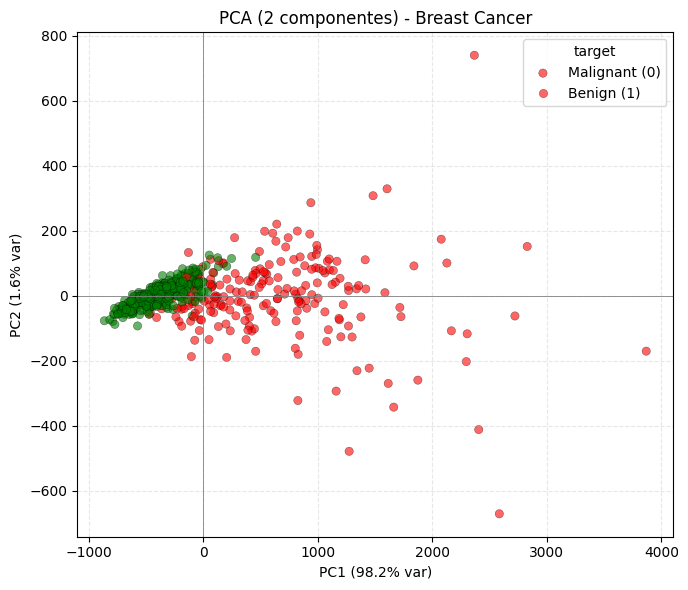

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supongo que ya tienes X_pca (2 componentes) y pca
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["target"] = y  # 0/1

plt.figure(figsize=(7,6))
ax = sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="target",
    palette={0: "red", 1: "green"},
    alpha=0.6,          # <- transparencia
    edgecolor="k", linewidth=0.3
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
ax.set_title('PCA (2 componentes) - Breast Cancer')
ax.axhline(0, color='gray', lw=0.6)
ax.axvline(0, color='gray', lw=0.6)
ax.grid(True, ls='--', alpha=0.3)
ax.legend(title="target", labels=["Malignant (0)", "Benign (1)"])
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 42
N_SPLITS = 5

# Datos
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# CV estratificada
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Utilidad para evaluar un pipeline con ACC y ROC-AUC
def eval_model(model, name):
    scores = cross_validate(model, X, y, cv=cv,
                            scoring=['accuracy', 'roc_auc'], n_jobs=-1)
    return pd.Series({
        "model": name,
        "acc_mean": scores["test_accuracy"].mean(),
        "acc_std":  scores["test_accuracy"].std(),
        "roc_mean": scores["test_roc_auc"].mean(),
        "roc_std":  scores["test_roc_auc"].std()
    })

# --- Pipelines: StandardScaler -> PCA(2) -> Clasificador ---
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3, random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3, random_state=RANDOM_STATE)),
    ("clf", KNeighborsClassifier(n_neighbors=5))
])

# Evaluación rápida
res = pd.concat([
    eval_model(pipe_lr,  "Logistic (PC1,PC2)"),
    eval_model(pipe_knn, "KNN-5 (PC1,PC2)")
], axis=1).T

print("=== CV estratificada ({} folds) ===".format(N_SPLITS))
print(res)

=== CV estratificada (5 folds) ===
                model  acc_mean   acc_std  roc_mean   roc_std
0  Logistic (PC1,PC2)  0.942059  0.019618  0.991886  0.004448
1     KNN-5 (PC1,PC2)   0.93324  0.021137  0.980847  0.010134


In [19]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

RANDOM_STATE = 42

# === Datos
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# === Split estratificado (holdout)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# === Pipeline base: StandardScaler -> PCA(2) -> LR
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=3, random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

def eval_on_test(model, name="LR+PCA(2)"):
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {name} — métricas en TEST ===")
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred, zero_division=0), 3))
    print("Recall   :", round(recall_score(y_test, y_pred), 3))
    print("F1       :", round(f1_score(y_test, y_pred), 3))
    print("ROC-AUC  :", round(roc_auc_score(y_test, y_proba), 3))

    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    print("\nMatriz de confusión [[TN, FP],[FN, TP]]:\n", cm)
    # (opc) informe clasificador
    # print("\n", classification_report(y_test, y_pred, digits=3))
    return {"model": model, "cm": cm}

# ---- 1) Modelo base en TEST
_ = eval_on_test(pipe_lr, "Base LR + PCA(2)")

# ---- 2) GridSearchCV (PCA(2) fijo) y misma evaluación en TEST
param_grid = {
    "pca__n_components": [2,3,8],        # mantener PC1 y PC2
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__solver": ["liblinear", "lbfgs"],
    "clf__class_weight": [None, "balanced"],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(
    pipe_lr, param_grid=param_grid, cv=cv,
    scoring="roc_auc", n_jobs=-1, refit=True
)
gs.fit(X_train, y_train)

print("\nMejores hiperparámetros (CV, métrica ROC-AUC):", gs.best_params_)
print("Mejor ROC-AUC medio en CV:", round(gs.best_score_, 4))

best_model = gs.best_estimator_
_ = eval_on_test(best_model, "Best LR + PCA(2) (GridSearchCV)")



=== Base LR + PCA(2) — métricas en TEST ===
Accuracy : 0.921
Precision: 0.957
Recall   : 0.917
F1       : 0.936
ROC-AUC  : 0.99

Matriz de confusión [[TN, FP],[FN, TP]]:
 [[39  3]
 [ 6 66]]

Mejores hiperparámetros (CV, métrica ROC-AUC): {'clf__C': 1, 'clf__class_weight': None, 'clf__solver': 'lbfgs', 'pca__n_components': 8}
Mejor ROC-AUC medio en CV: 0.995

=== Best LR + PCA(2) (GridSearchCV) — métricas en TEST ===
Accuracy : 0.956
Precision: 0.986
Recall   : 0.944
F1       : 0.965
ROC-AUC  : 0.994

Matriz de confusión [[TN, FP],[FN, TP]]:
 [[41  1]
 [ 4 68]]
